# Compare captioning models
This notebook compares the performance of 2 captioning models:
- Paligemma 3b mix 448: requires a GPU and an huggingface token to access the model
- Gemini Flash 1.5 (version 2.0): requires a gemini API key

For the Paligemma model a GPU is required. Use the `dev-docker-compose.yml` file to run this notebook.

The conclusion is that for the minifigures, Gemini Flash performs significantly better than Paligemma.

In [1]:
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from PIL import Image
import datasets
import torch
import os
import google.generativeai as genai
from IPython.display import display
from matplotlib import pyplot as plt

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hf_token = os.environ["HF_TOKEN"]
gemini_api_key = os.environ["GEMINI_API_KEY"]

In [3]:
dataset = datasets.load_dataset(
    "armaggheddon97/lego_minifigure_captions",
    split="minifigures",
    streaming=True
)

In [4]:
PALIGEMMA_PROMPT = (
    "Describe the LEGO minifigure briefly, focusing on its clothes, "
    "accessories, and theme."
)

GEMINI_PROMPT = (
    "You are a precise and detailed image captioning assistant. Your task is "
    "to describe LEGO minifigures in a single sentence, focusing on their "
    "unique features, such as attire, accessories, facial expression, "
    "and theme. Avoid generic terms and aim for specificity, "
    "while remaining concise."
)

In [5]:
def caption_with_paligemma(rows: list):
    model_id = "google/paligemma-3b-mix-448"
    model = PaliGemmaForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        device_map="cuda:0",
        revision="bfloat16",
        token=hf_token
    ).eval()
    processor = AutoProcessor.from_pretrained(model_id)

    captions = []
    for row in rows:
        model_inputs = processor(
            text=PALIGEMMA_PROMPT,
            images=row["image"],
            return_tensors="pt"
        ).to(dtype=torch.bfloat16, device=model.device)

        input_len = model_inputs["input_ids"].shape[-1]
        with torch.inference_mode():
            generation = model.generate(
                **model_inputs,
                max_new_tokens=512,
                do_sample=False
            )
            generation = generation[0][input_len:]
            decoded = processor.decode(generation, skip_special_tokens=True)
            captions.append(decoded)
    return captions

In [6]:
def caption_with_gemini(rows: list):
    genai.configure(api_key=gemini_api_key)
    gemini_flash = genai.GenerativeModel("gemini-1.5-flash")

    captions = []
    for row in rows:
        response = gemini_flash.generate_content([GEMINI_PROMPT, row["image"]])
        captions.append(response.text)
    return captions

In [7]:
ds_iter = iter(dataset)
rows = [next(ds_iter) for _ in range(10)]

In [8]:
paligemma_captions = caption_with_paligemma(rows)
gemini_captions = caption_with_gemini(rows)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.74s/it]
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` t

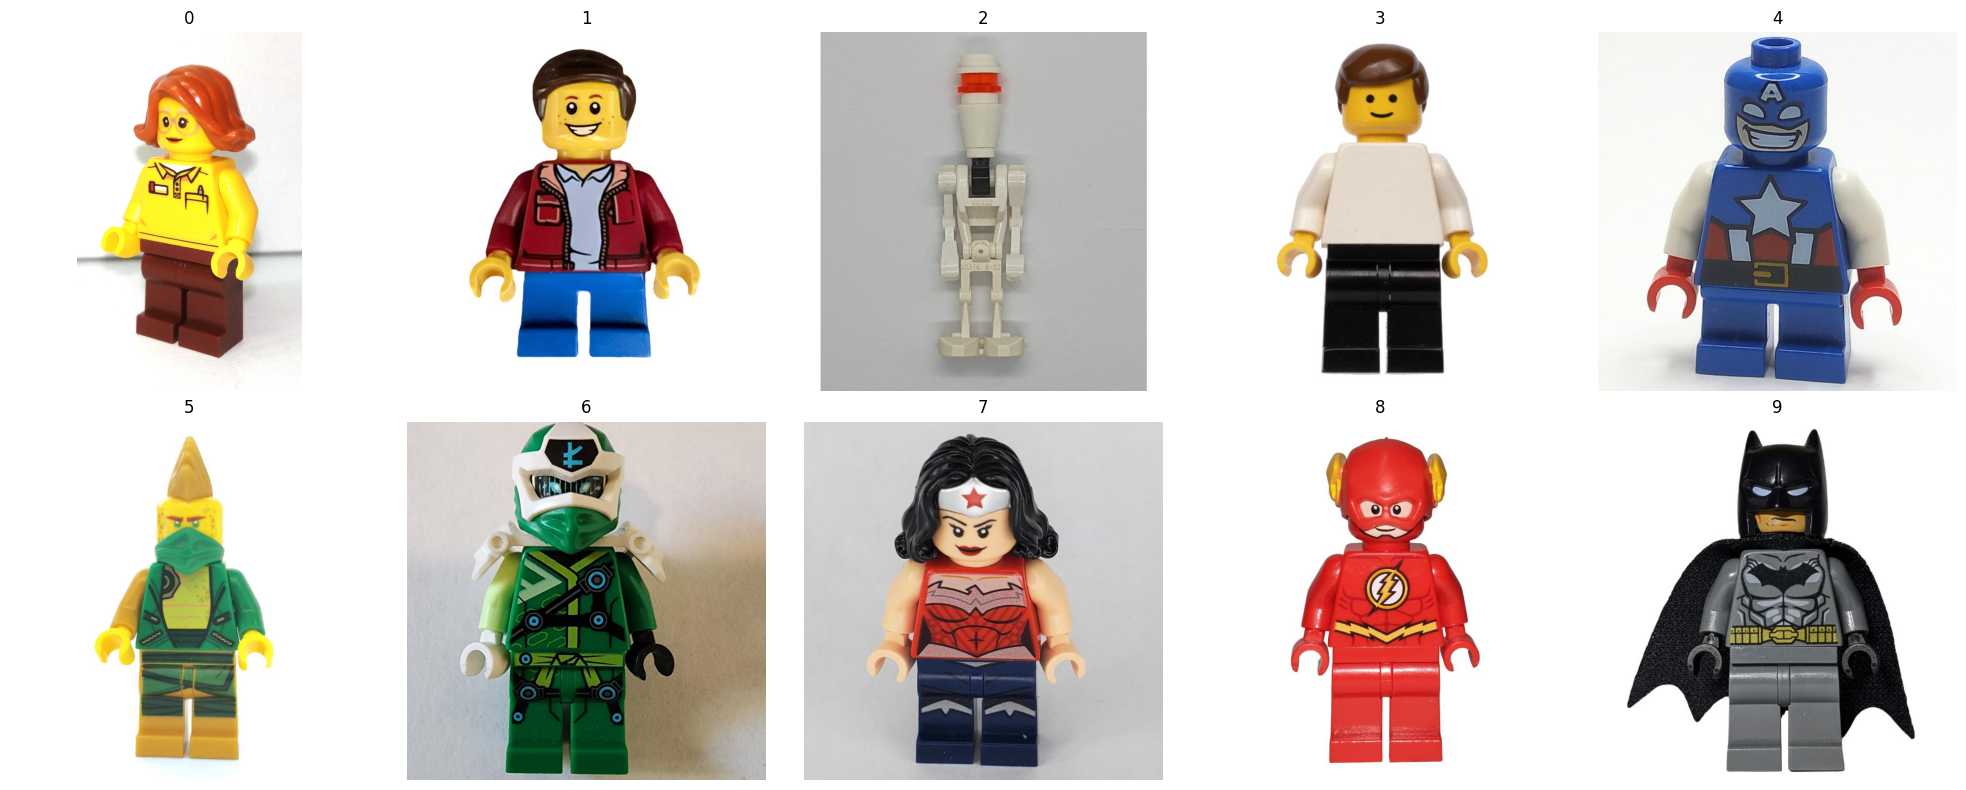

In [15]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, row in enumerate(rows):
    ax = axs[i // 5, i % 5]
    ax.imshow(row["image"])
    ax.axis("off")
    ax.set_title(f"{i}")
plt.tight_layout()

In [14]:
for i, (paligemma_caption, gemini_caption) in enumerate(zip(paligemma_captions, gemini_captions)):
    print(f"[{i}]:")
    print(f"\t-Paligemma: {paligemma_caption}")
    print(f"\t-Gemini: {gemini_caption}")
    print("=" * 80 + "")

[0]:
	-Paligemma: the lego minifigure has a yellow shirt with a red and black logo, brown pants, and red hair.
	-Gemini: A cheerful LEGO minifigure woman with auburn hair, wearing glasses, a yellow collared shirt with a logo and pen pocket, and dark brown trousers, displays a pleasant expression.

[1]:
	-Paligemma: the lego minifigure has a red jacket, blue pants, and brown hair.
	-Gemini: A smiling LEGO minifigure with brown hair, freckled yellow skin, and a maroon zip-up jacket over a light blue shirt, paired with royal blue pants, suggests a casual or everyday theme.

[2]:
	-Paligemma: The minifigure is a white robot with an orange light on its head.
	-Gemini: A white LEGO Star Wars Super Battle Droid minifigure features a distinctive orange-ringed headpiece, articulated limbs, and a blank facial expression.

[3]:
	-Paligemma: the lego minifigure has brown hair, black pants, and a white shirt.
	-Gemini: A smiling LEGO minifigure with brown hair, wearing an off-white long-sleeved shi